Submitted By - Maitri Das

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Segmentation_Inpainting'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Segmentation_Inpainting


## Installations

In [2]:
!pip install psenet-text-detector

     |████████████████████████████████| 28.3 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!git clone https://github.com/saic-mdal/lama.git
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

fatal: destination path 'lama' already exists and is not an empty directory.


In [4]:
cd lama

/content/drive/MyDrive/Segmentation_Inpainting/lama


In [5]:
!pip install -r requirements.txt 
!pip3 install wldhx.yadisk-direct
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 12.5 MB 13.9 MB/s 
     |████████████████████████████████| 22.3 MB 2.0 MB/s 
     |████████████████████████████████| 72 kB 351 kB/s 
     |████████████████████████████████| 144 kB 50.2 MB/s 
     |████████████████████████████████| 841 kB 44.4 MB/s 
     |████████████████████████████████| 271 kB 49.5 MB/s 
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 948 kB 50.1 MB/s 
     |████████████████████████████████| 47.8 MB 1.7 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 80.5 MB/s 
     |████████████████████████████████| 136 kB 70.1 MB/s 
     |████████████████████████████████| 829 kB 54.7 MB/s 
     |████████████████████████████████| 176 kB 67.6 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
     |████████████████████████████████| 1.1 MB 51.0 MB/s 
     |████████████████████████████████| 462 kB 66.8 MB/s 
     |█████████████

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  363M    0  363M    0     0   9.9M      0 --:--:--  0:00:36 --:--:-- 9974k
Archive:  big-lama.zip
replace big-lama/config.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace big-lama/models/best.ckpt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/open

In [6]:
cd ..

/content/drive/MyDrive/Segmentation_Inpainting


## Import the libraries

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
import glob
import pandas as pd
import PIL.Image as Image
### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from google.colab.patches import cv2_imshow
%matplotlib inline

from torchvision.transforms.functional import convert_image_dtype
import torch
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
import torchvision.transforms.functional as F

## Load the test directory

Converting .png file to .jpg

In [ ]:
test_path = "test/"

# Check images directory
png_list = [os.path.basename(filename).split('.')[0] for filename in glob.glob(test_path+"/*.png")]
for id in png_list:
  img = Image.open(test_path+id[0]+'.png')
  img = img.convert('RGB')
  img.save(test_path+id[0]+'.jpg')
  os.remove(test_path+id[0]+'.png')

list of all images in test directory

In [ ]:
test_path = "test/"

# Check images directory
test_list = [os.path.basename(filename).split('.')[0] for filename in glob.glob(test_path+"/*.jpg")]
test_ids = pd.DataFrame(test_list).rename(columns={0:"image_id"})
print(f"Number of images in the images directory: {len(test_ids)}")
test_ids.head()
test_ids = test_ids.values.tolist()

Number of images in the images directory: 6


Resizing the images into (512, 512) shape

In [ ]:
def center_crop(pil_img, crop_width=1024, crop_height=1024):
  img_width, img_height = pil_img.size
  return pil_img.crop(((img_width-crop_width)//2,
                      (img_height-crop_height)//2,
                      (img_width + crop_width)//2,
                      (img_height+crop_height)//2))
  
for img in test_ids:
  im = Image.open(test_path+img[0]+".jpg")
  # im = center_crop(im)
  im = im.resize((512, 512))
  im.save(test_path+img[0]+".jpg")

Converting the images into batch of tensors to insert in our object detection model

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
out = []
for img in test_ids:
  I = cv2.imread(test_path+img[0]+'.jpg')
  tensor = transform(I)
  tensor = tensor.unsqueeze(0)
  print(tensor.shape)
  out.append(tensor)

tensor_out = torch.cat(out, dim=0)

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [ ]:
tensor_out.shape

torch.Size([6, 3, 512, 512])

In [ ]:
batch = convert_image_dtype(tensor_out, dtype=torch.float)

## Getting output from our object detection model

The object detection model is pretrained fcn_resnet50, we extract the human segmentation mask from the model for our purpose

In [ ]:
object_model = fcn_resnet50(pretrained=True, progress=False)
object_model = object_model.eval()

normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = object_model(normalized_batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([6, 21, 512, 512]) -4.64704704284668 13.575246810913086


In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Visualizing our outputs

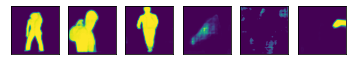

In [ ]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

person_masks = [
    normalized_masks[img_idx, sem_class_to_idx['person']]
    for img_idx in range(batch.shape[0])
]

show(person_masks)

In [ ]:
def generate_mask(imgs):
  '''
  A funtion to generate binary masks for object detection model
  '''
  object_masks = {}
  for i in range(0, len(imgs)):
    img = F.to_pil_image(imgs[i])
    img = np.asarray(img)
    m = np.zeros(img.shape, np.uint8)
    m[:, :] = np.where((img[:, :]<100), 0, 255)
    object_masks[test_ids[i][0]] = m
    # print(f"Image ID and object mask: {test_ids[i][0]}")
    # cv2_imshow(m)
    org_img = np.asarray(Image.open(test_path+test_ids[i][0]+'.jpg'))
    NUM_ROWS = 1
    IMGs_IN_ROW = 3
    f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(10,10))

    ax[0].imshow(org_img)
    ax[1].imshow(img)
    ax[2].imshow(m)

    ax[0].set_title(f'Original Image :{test_ids[i][0]}.jpg')
    ax[1].set_title('Mask generated by the model')
    ax[2].set_title('Binary mask')

  return object_masks

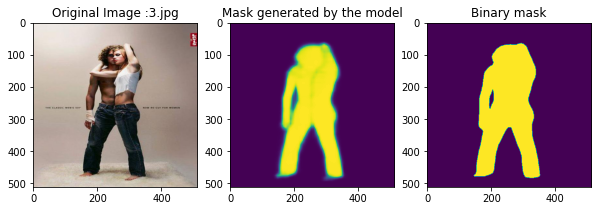

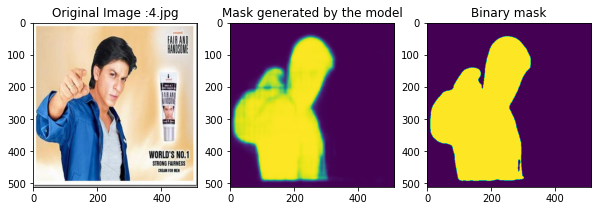

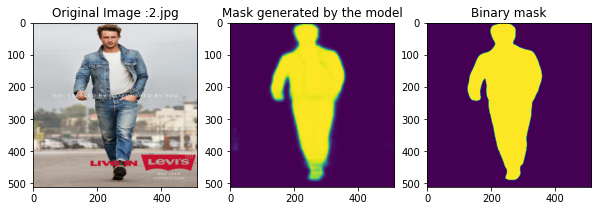

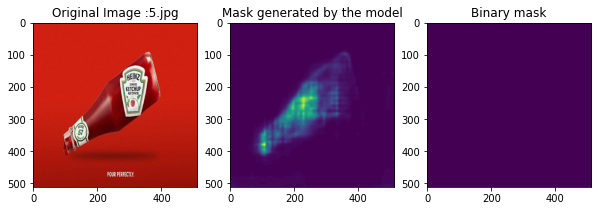

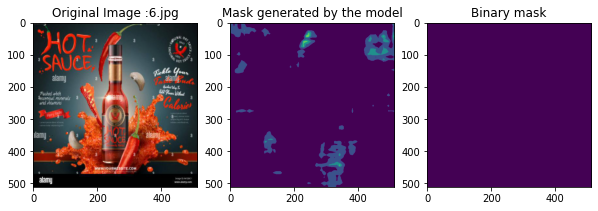

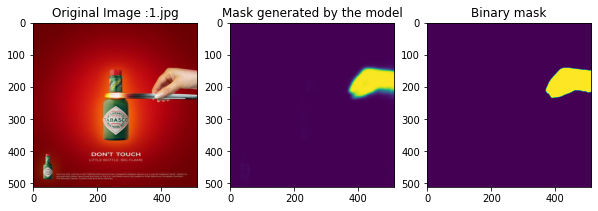

In [ ]:
object_masks = generate_mask(person_masks)

## Text detection

In [ ]:
os.makedirs('pred', exist_ok=True)

For text detection model psenet_test_detector is used which gives bounding boxes as output

In [ ]:
import psenet_text_detector as psenet
output_dir = 'pred'
preds = {}
for img in test_ids:
  # read image
  image_path = f"test/{img[0]}.jpg"
  image = psenet.read_image(image_path)

  # load model
  psenet_model = psenet.load_psenet_model()

  # perform prediction
  prediction_result = psenet.get_prediction(image=image,
                               		  model=psenet_model,
                                       	  binary_th=1.0,
                                       	  kernel_num=3,
                                       	  upsample_scale=1,
                                       	  long_size=1280,
                                       	  min_kernel_area=10.0,
                                       	  min_area=300.0,
                                       	  min_score=0.93,
                                       	  cuda=False)

  # export detected text regions
  exported_file_paths = psenet.export_detected_regions(image_path,
                                              	    image,
                                              	    boxes=prediction_result["boxes"],
                                              	    output_dir=output_dir)
  preds[img[0]] = prediction_result["boxes"]

  # export box visualization
  _ = psenet.visualize_detection(image_path,
            		       image=image,
        		       quads=prediction_result["boxes"],
                    	       output_dir=output_dir)

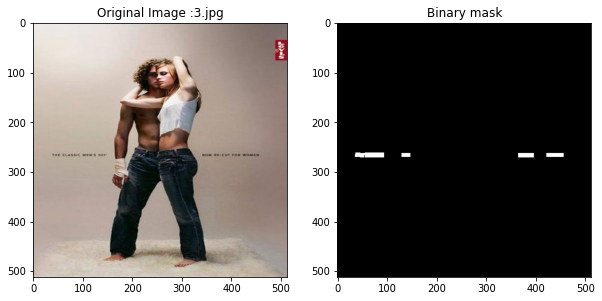

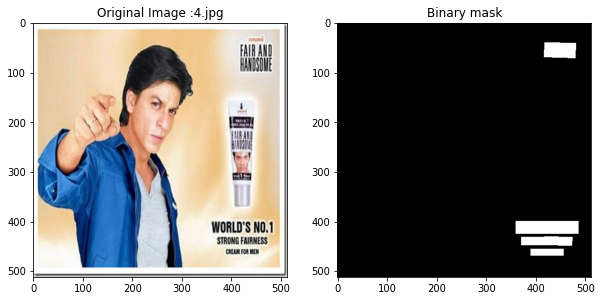

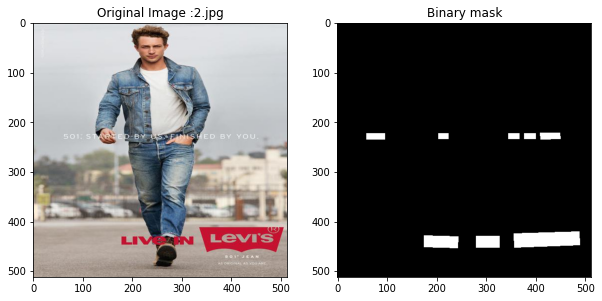

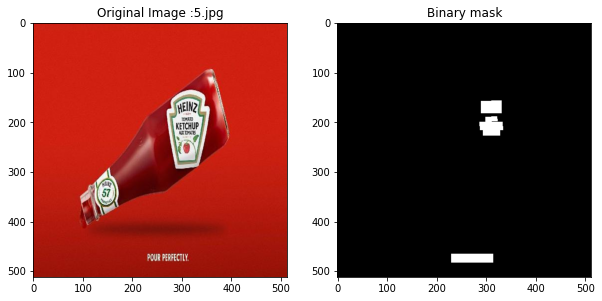

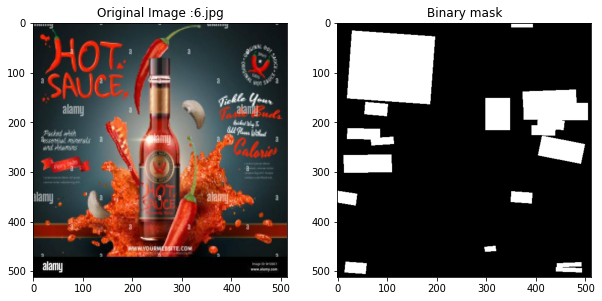

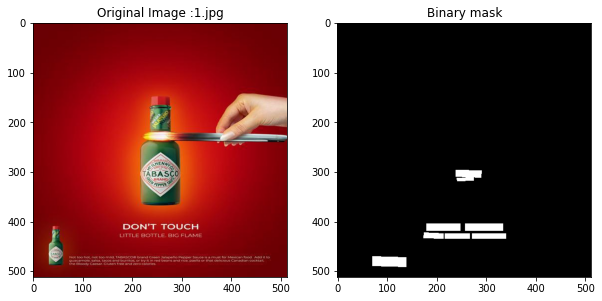

In [ ]:
# creating mask
text_masks = {}
for img in preds.keys():
  im = cv2.imread(test_path+img+".jpg")
  m = np.zeros(im.shape, np.uint8)
  bin_m = np.zeros((im.shape[0], im.shape[1]), np.uint8)
  for box in preds[img]:
    np_box = np.array([[pair] for pair in box])
    cv2.drawContours(m, [np_box], -1, (255, 255, 255), -1)
    bin_m[:, :] = np.max(m, axis=2)
  text_masks[img] = bin_m
  NUM_ROWS = 1
  IMGs_IN_ROW = 2
  f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(10,10))

  im = im[:,:,::-1]
  ax[0].imshow(im)
  ax[1].imshow(m)

  ax[0].set_title(f'Original Image :{img}.jpg')
  ax[1].set_title('Binary mask')

## Merging Text Masks and object Masks to image

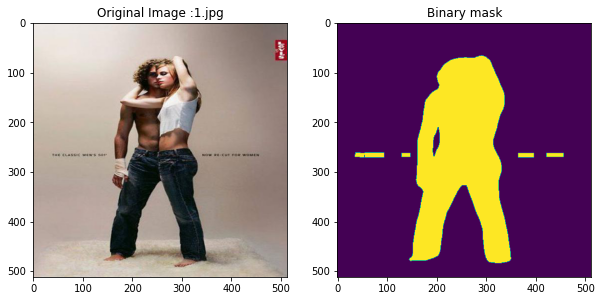

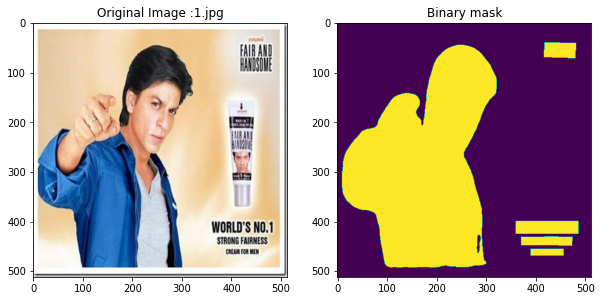

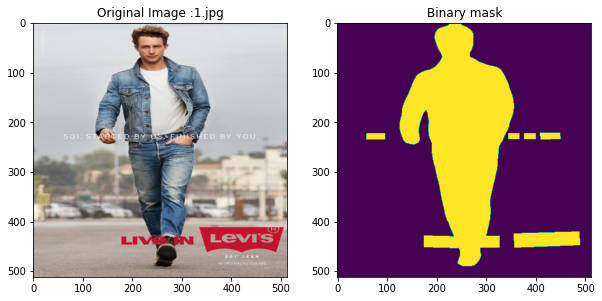

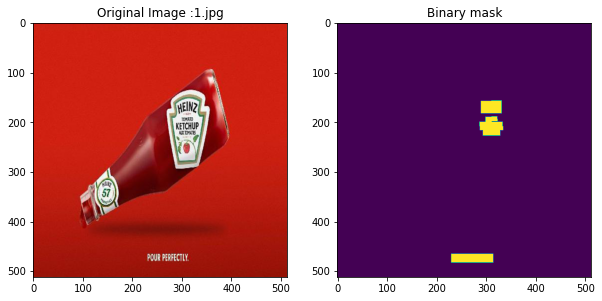

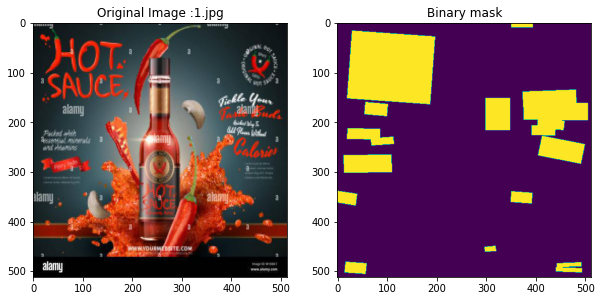

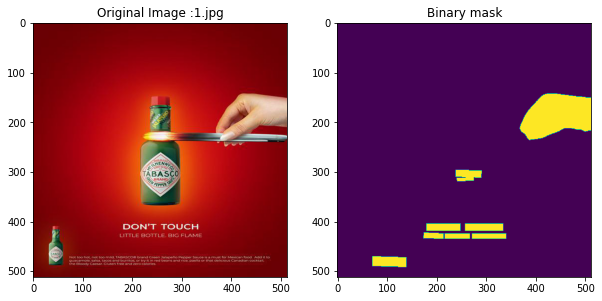

In [ ]:
out_dir = "lama/data_for_prediction/"
os.makedirs(out_dir, exist_ok=True)
for id in text_masks.keys():
  NUM_ROWS = 1
  IMGs_IN_ROW = 2
  f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(10,10))

  mask = np.zeros(text_masks[id].shape)
  mask = np.maximum(text_masks[id], object_masks[id])
  # im = Image.open(test_path + id + '.jpg')
  im = np.array(Image.open(test_path + id + '.jpg'))
  ax[0].imshow(im)
  # print(test_path + id + '.jpg')
  # display(im)
  org = Image.fromarray(im)
  org.save(out_dir + id + ".jpg")
  im = im[:,:,::-1] # convert BRG to RGB
  # cv2_imshow(im)
  im[:, :, 0] = np.where((mask[:, :]==255), 0, im[:,:,0])
  im[:, :, 1] = np.where((mask[:, :]==255), 0, im[:,:,1])
  im[:, :, 2] = np.where((mask[:, :]==255), 0, im[:,:,2])
  # print(f"Image ID: {id}")
  # cv2_imshow(im)
  im = Image.fromarray(mask)
  im.save(out_dir + id + "_mask.png")

  ax[1].imshow(im)

  ax[0].set_title(f'Original Image :{img}.jpg')
  ax[1].set_title('Binary mask')

## LAMA

In [ ]:
pwd

'/content/drive/MyDrive/Segmentation_Inpainting'

In [ ]:
output_imp = "output"
os.makedirs(output_imp, exist_ok=True)

In [ ]:
cd lama

/content/drive/MyDrive/Segmentation_Inpainting/lama


In [ ]:
!PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/drive/MyDrive/Segmentation_Inpainting/output dataset.img_suffix=.jpg > /dev/null

100% 6/6 [00:06<00:00,  1.05s/it]


## Visualizing the results

In [ ]:
cd ..

/content/drive/MyDrive/Segmentation_Inpainting


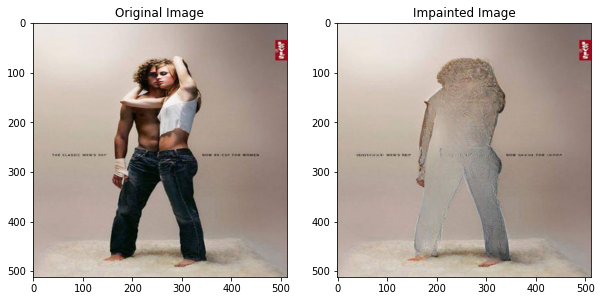

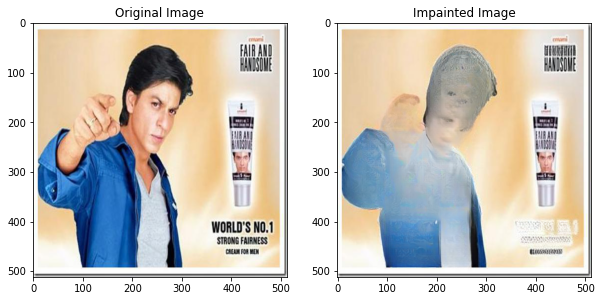

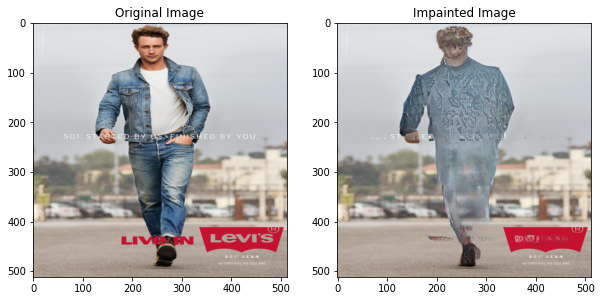

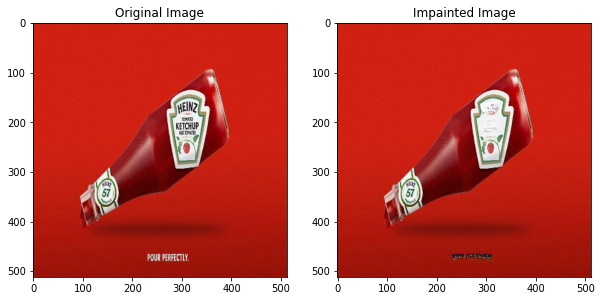

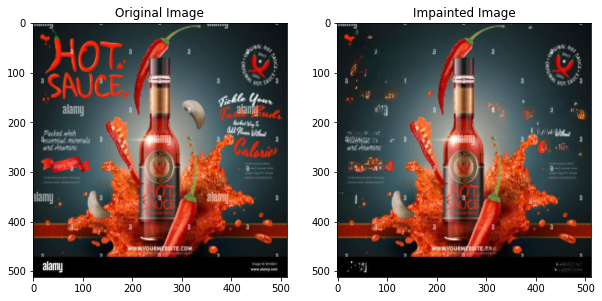

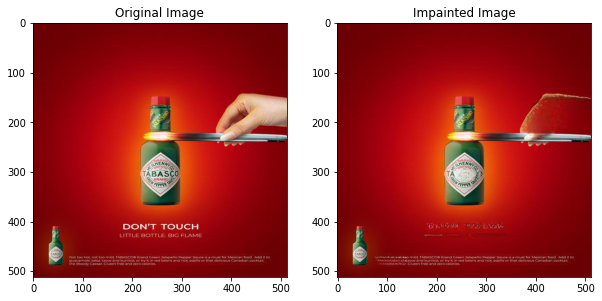

In [ ]:
for id in test_ids:
  ori_img = Image.open(test_path+id[0]+'.jpg')
  impainted_img = Image.open(output_imp+"/"+id[0]+'_mask.png')
  NUM_ROWS = 1
  IMGs_IN_ROW = 2
  f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(10,10))

  ax[0].imshow(ori_img)
  ax[1].imshow(impainted_img)

  ax[0].set_title('Original Image')
  ax[1].set_title('Impainted Image')